In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, space_eval
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error
import util

In [2]:
def score(params):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose=False)
    y_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, y_pred)
    return {"loss": score, "status": "ok"}

In [3]:
X_train = pd.read_parquet("./modelling_data/X_train.parquet")
y_train = pd.read_parquet("./modelling_data/y_train.parquet")["target"]
X_valid = pd.read_parquet("./modelling_data/X_validation.parquet")
y_valid = pd.read_parquet("./modelling_data/y_validation.parquet")["target"]

<AxesSubplot:>

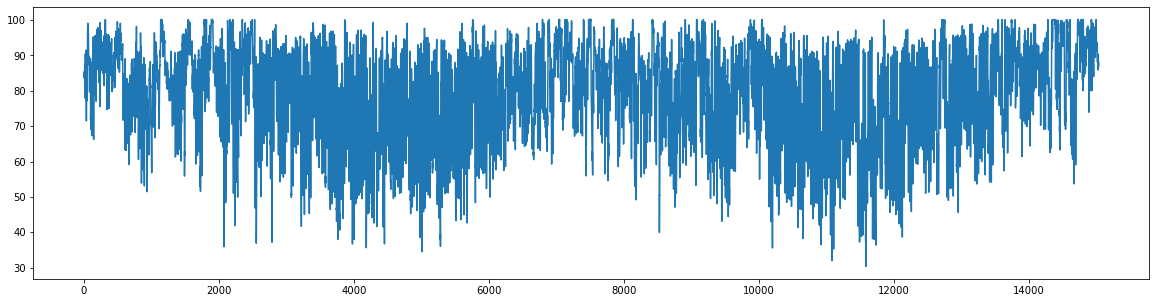

In [4]:
X_train["AH"].plot(figsize=(20, 5))

<AxesSubplot:>

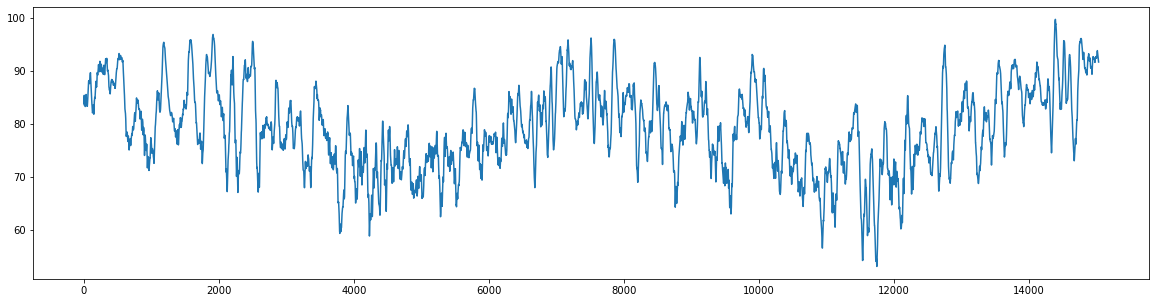

In [5]:
(X_train["AH"]
 .rolling(50, min_periods=10)
 .mean()
 .fillna(X_train["AH"])).plot(figsize=(20, 5))

<AxesSubplot:>

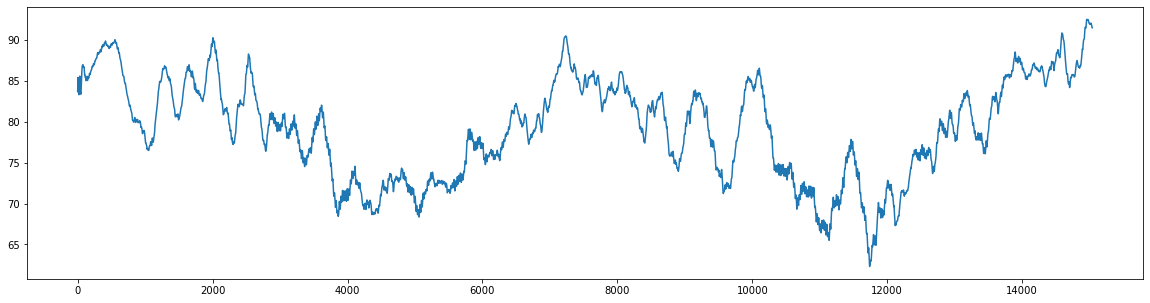

In [6]:
(X_train["AH"]
 .rolling(250, min_periods=10)
 .mean()
 .fillna(X_train["AH"])).plot(figsize=(20, 5))

In [7]:
X_train_roll = (X_train
 .rolling(50, min_periods=10)
 .mean()
 .fillna(X_train))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

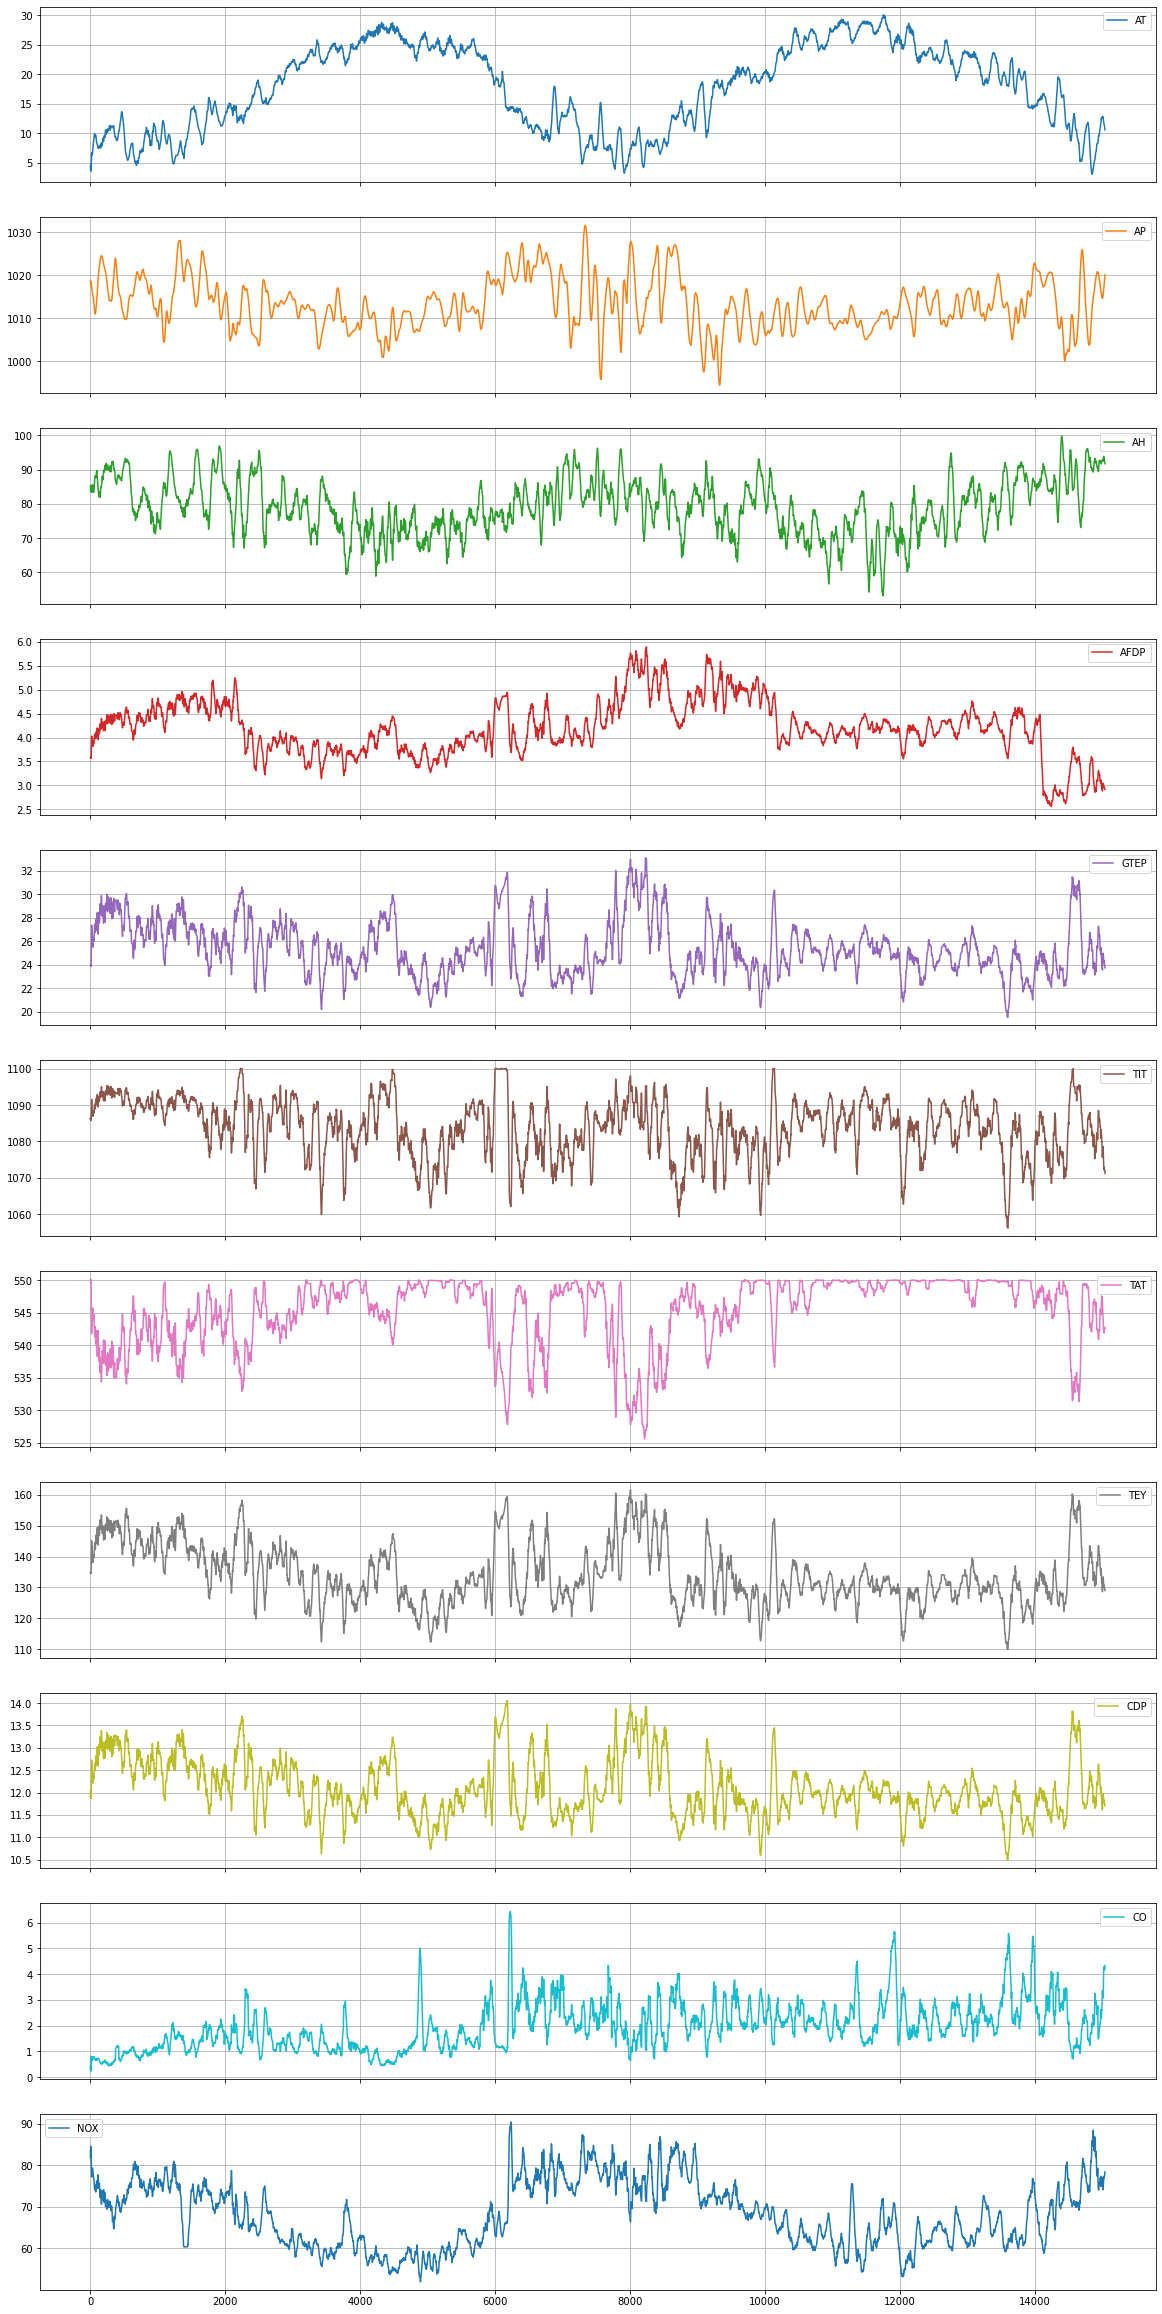

In [8]:
X_train_roll.plot.line(subplots=True, figsize=(20, 42), grid=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

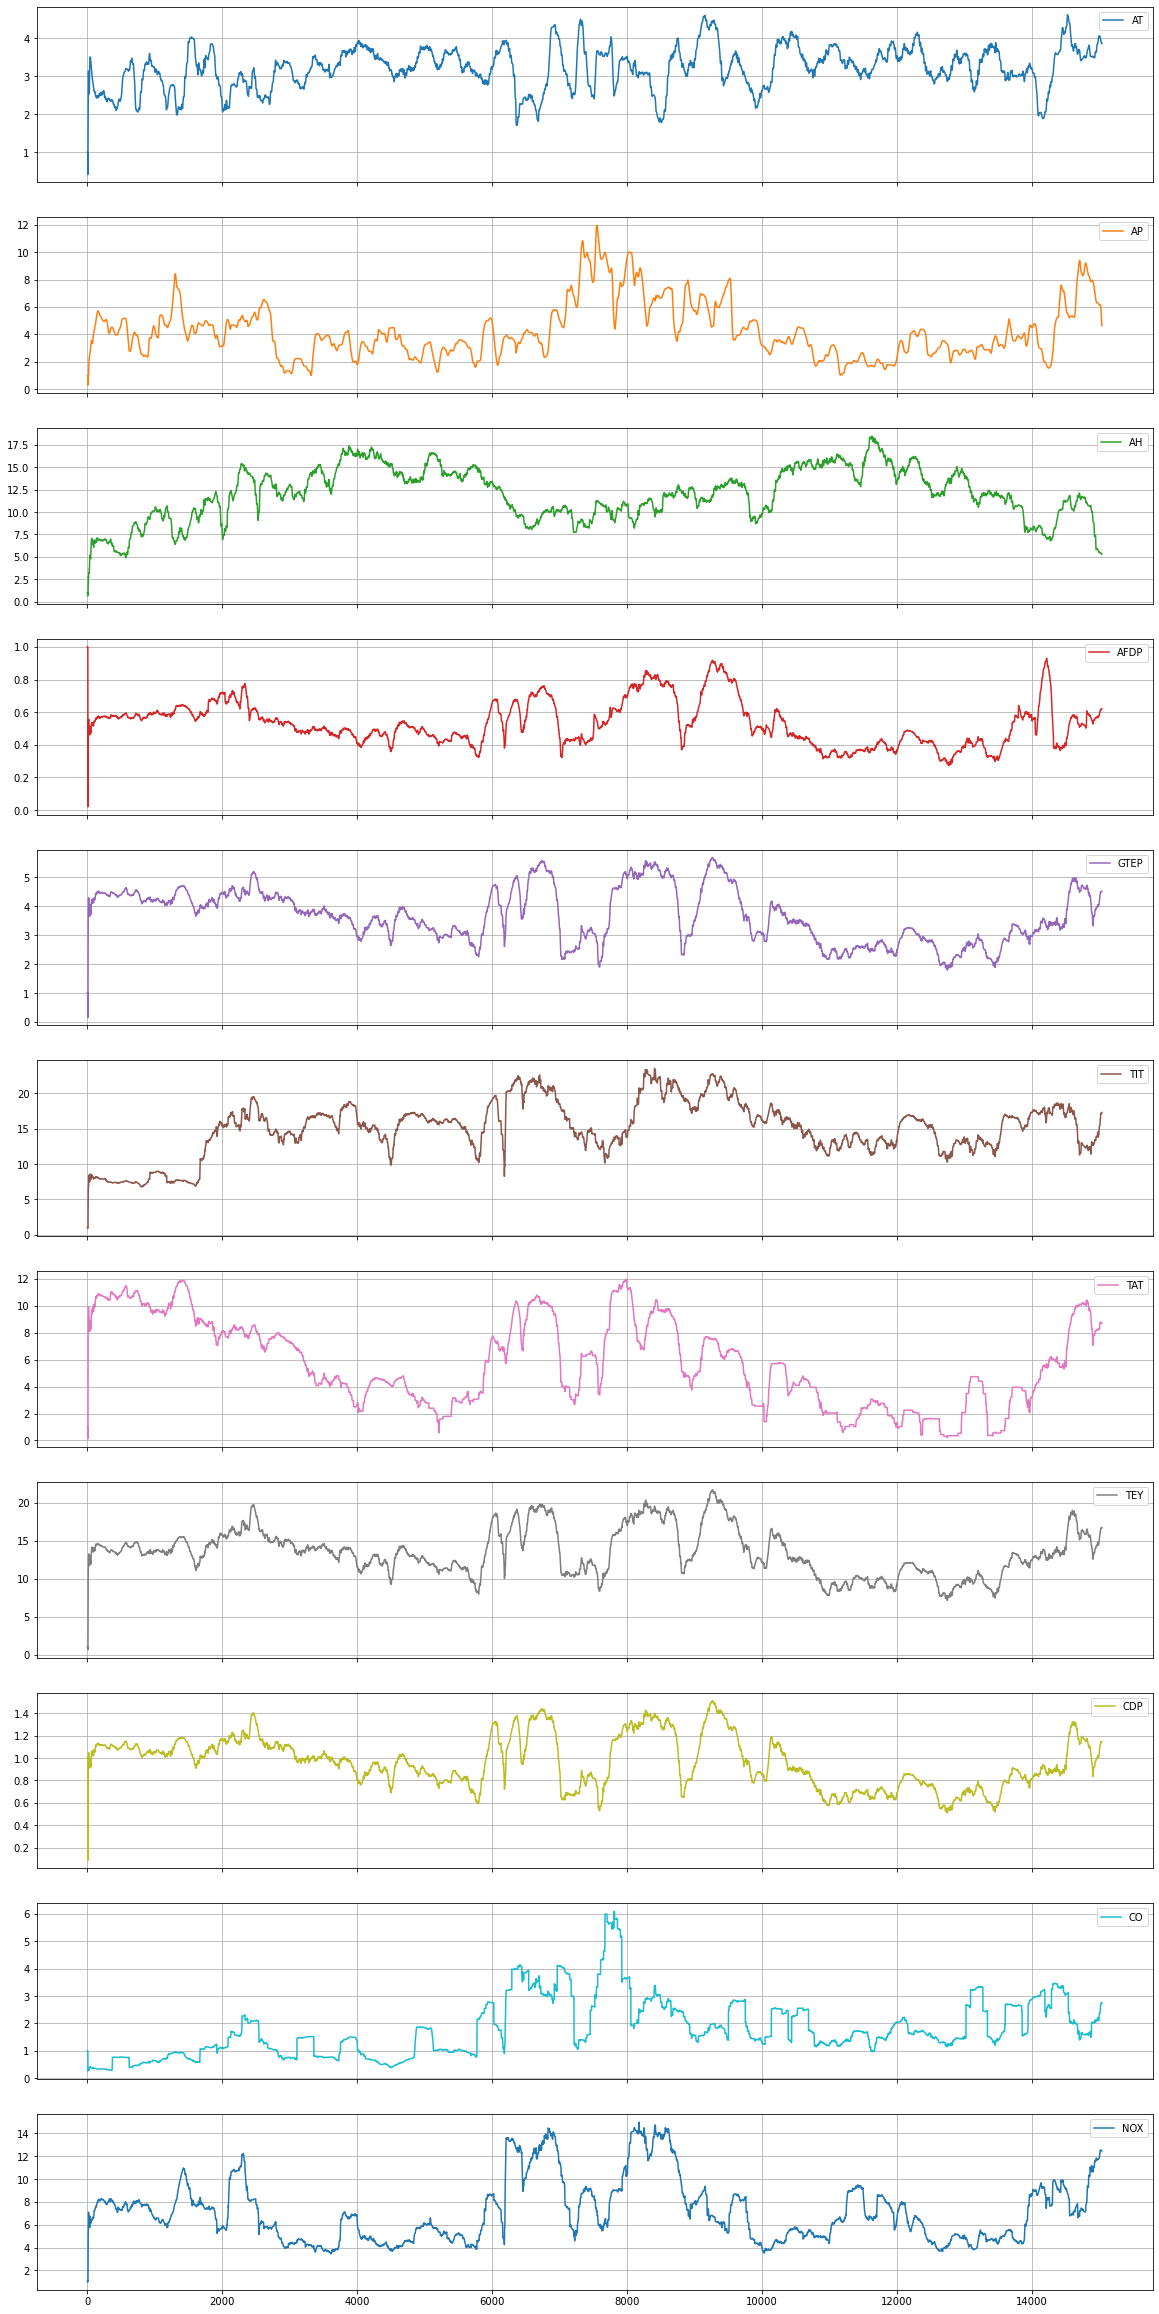

In [9]:
(X_train
 .rolling(250, min_periods=10)
 .std()
 .fillna(1)[[col for col in X_train if 'ROLL' not in col]]
 .plot
 .line(subplots=True, figsize=(20, 42), grid=True))

In [10]:
def rolling_means(df, window, min_periods, cols=None):
    cols = cols or df.columns.to_list()
    df_roll = (df[cols]
               .rolling(window, min_periods=min_periods)
               .mean()
               .fillna(df))
    df_roll.columns = df_roll.columns.map(lambda c: f"{c}_ROLL{window}_MEAN")
    return df_roll


def rolling_standard_deviation(df, window, min_periods, cols=None):
    cols = cols or df.columns.to_list()
    df_roll = (df[cols]
               .rolling(window, min_periods=min_periods)
               .std()
               .fillna(1))
    df_roll.columns = df_roll.columns.map(lambda c: f"{c}_ROLL{window}_STD")
    return df_roll


def lagged_features(df, lags, cols=None):
    if isinstance(lags, int):
        lags = range(1, lags+1)
    cols = cols or df.columns.to_list()
    data = []
    for lag in lags:
        lagged_data = df[cols].shift(lag).fillna(df)
        lagged_data.columns = lagged_data.columns.map(lambda c: f"{c}_LAG{lag}")
        data.append(lagged_data)
    return pd.concat(data, axis="columns")

In [11]:
X_train["FEAT1"] = X_train["TIT"]/X_train["TAT"]
X_train["FEAT2"] = X_train['AT'].diff().fillna(0)
X_train["FEAT3"] = np.log(np.abs(X_train["AH"]/X_train["AT"]))
X_train["FEAT4"] = 5*np.round(X_train["TEY"]/5)
X_train["FEAT5"] = np.round(X_train["CDP"])
X_train["FEAT6"] = np.round(X_train["AFDP"])

X_valid["FEAT1"] = X_valid["TIT"]/X_valid["TAT"]
X_valid["FEAT2"] = X_valid['AT'].diff().fillna(0)
X_valid["FEAT3"] = np.log(np.abs(X_valid["AH"]/X_valid["AT"]))
X_valid["FEAT4"] = 5*np.round(X_valid["TEY"]/5)
X_valid["FEAT5"] = np.round(X_valid["CDP"])
X_valid["FEAT6"] = np.round(X_valid["AFDP"])

X_train = pd.concat([
    X_train,
    util.rolling_means(X_train, 50, 2, cols=[col for col in X_train.columns if "FEAT" in col]),
    util.rolling_means(X_train, 250, 10, cols=["TEY", "TAT", "AT", "NOX"]),
    util.rolling_standard_deviation(X_train, 250, 10, cols=["CO"]),
    util.lagged_features(X_train, 1, [col for col in X_train.columns if "FEAT" not in col]),
    util.lagged_features(X_train, [2, 3], ["TEY"])
], axis="columns")

X_valid = pd.concat([
    X_valid,
    util.rolling_means(X_valid, 50, 2, cols=[col for col in X_valid.columns if "FEAT" in col]),
    util.rolling_means(X_valid, 250, 10, cols=["TEY", "TAT", "AT", "NOX"]),
    util.rolling_standard_deviation(X_valid, 250, 10, cols=["CO"]),
    util.lagged_features(X_valid, 1, [col for col in X_valid.columns if "FEAT" not in col]),
    util.lagged_features(X_valid, [2, 3], ["TEY"])
], axis="columns")

print(X_train.shape, X_valid.shape)

(15039, 41) (7152, 41)


In [12]:
param_space = {
    "max_depth": hp.choice("max_depth", np.linspace(2, 8, 7, dtype=int)),
    "gamma": hp.choice("gamma", np.linspace(5, 25, 21)),
    "n_estimators": hp.choice("n_estimators", np.linspace(50, 500, 45, dtype=int)),
    "colsample_bytree": hp.choice("colsample_bytree", np.linspace(0.3, 1, 8)),
    "subsample": hp.quniform("subsample", 0.75, 1.0, 0.1),
    "eta": hp.uniform("eta", 0.001, 0.1),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 20, 21, dtype=int)),
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 0
}

In [13]:
trials = Trials()
best_params_loc = fmin(score, param_space, algo=tpe.suggest, max_evals=175, trials=trials)
optimal_params = space_eval(param_space, best_params_loc)

100%|██████████| 175/175 [09:52<00:00,  3.39s/trial, best loss: 60.09184837833582]


In [14]:
optimal_params

{'colsample_bytree': 1.0,
 'eta': 0.04918344425165719,
 'eval_metric': 'rmse',
 'gamma': 16.0,
 'max_depth': 7,
 'min_child_weight': 19,
 'n_estimators': 326,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'subsample': 0.8}

In [15]:
X_train = pd.concat([X_train, X_valid])
y_train = pd.concat([y_train, y_valid])
X_test = pd.read_parquet("./modelling_data/X_test.parquet")
y_test = pd.read_parquet("./modelling_data/y_test.parquet")["target"]

X_test["FEAT1"] = X_test["TIT"]/X_test["TAT"]
X_test["FEAT2"] = X_test['AT'].diff().fillna(0)
X_test["FEAT3"] = np.log(np.abs(X_test["AH"]/X_test["AT"]))
X_test["FEAT4"] = 5*np.round(X_test["TEY"]/5)
X_test["FEAT5"] = np.round(X_test["CDP"])
X_test["FEAT6"] = np.round(X_test["AFDP"])

X_test = pd.concat([
    X_test,
    util.rolling_means(X_test, 50, 2, cols=[col for col in X_test.columns if "FEAT" in col]),
    util.rolling_means(X_test, 250, 10, cols=["TEY", "TAT", "AT", "NOX"]),
    util.rolling_standard_deviation(X_test, 250, 10, cols=["CO"]),
    util.lagged_features(X_test, 1, [col for col in X_test.columns if "FEAT" not in col]),
    util.lagged_features(X_test, [2, 3], ["TEY"])
], axis="columns")

print(X_test.shape)

(14534, 41)


In [16]:
model = xgb.XGBRegressor(**optimal_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True
)

[0]	validation_0-rmse:127.43696	validation_1-rmse:127.29140
[1]	validation_0-rmse:121.19905	validation_1-rmse:121.03451
[2]	validation_0-rmse:115.26965	validation_1-rmse:115.16121
[3]	validation_0-rmse:109.63300	validation_1-rmse:109.57076
[4]	validation_0-rmse:104.27599	validation_1-rmse:104.26598
[5]	validation_0-rmse:99.18182	validation_1-rmse:99.17695
[6]	validation_0-rmse:94.33859	validation_1-rmse:94.32182
[7]	validation_0-rmse:89.73747	validation_1-rmse:89.78331
[8]	validation_0-rmse:85.36459	validation_1-rmse:85.45469
[9]	validation_0-rmse:81.20861	validation_1-rmse:81.34390
[10]	validation_0-rmse:77.25605	validation_1-rmse:77.38743
[11]	validation_0-rmse:73.50018	validation_1-rmse:73.60910
[12]	validation_0-rmse:69.93343	validation_1-rmse:70.06598
[13]	validation_0-rmse:66.54480	validation_1-rmse:66.70379
[14]	validation_0-rmse:63.32329	validation_1-rmse:63.45746
[15]	validation_0-rmse:60.26197	validation_1-rmse:60.38817
[16]	validation_0-rmse:57.35294	validation_1-rmse:57.505

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.04918344425165719,
             eval_metric='rmse', gamma=16.0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0491834432,
             max_delta_step=0, max_depth=7, min_child_weight=19, missing=nan,
             monotone_constraints='()', n_estimators=326, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

MAE = 5.132668261860691
MSE = 61.602759003737454
RMSE = 7.848742510984639
MAPE = 0.03955701982319022
R^2 = 0.7254012171740715
Explained Variance Score = 0.7261848739514642

Residuals summary stats
╒═══════╤═══════════╕
│ count │     14534 │
├───────┼───────────┤
│ mean  │ -0.419289 │
├───────┼───────────┤
│ std   │    7.8378 │
├───────┼───────────┤
│ min   │  -48.7704 │
├───────┼───────────┤
│ 25%   │  -3.78666 │
├───────┼───────────┤
│ 50%   │ -0.959362 │
├───────┼───────────┤
│ 75%   │   2.27616 │
├───────┼───────────┤
│ max   │   51.2083 │
╘═══════╧═══════════╛

Deviation from mean of residuals
╒════════════╤══════════╤════════════╕
│ Interval   │   Actual │   Expected │
╞════════════╪══════════╪════════════╡
│ μ ± σ      │  81.5605 │       68.2 │
├────────────┼──────────┼────────────┤
│ μ ± 2σ     │  93.5186 │       95.4 │
├────────────┼──────────┼────────────┤
│ μ ± 3σ     │  97.6056 │       99.7 │
╘════════════╧══════════╧════════════╛

Jarque-Bera Test on Residuals
╒════════════

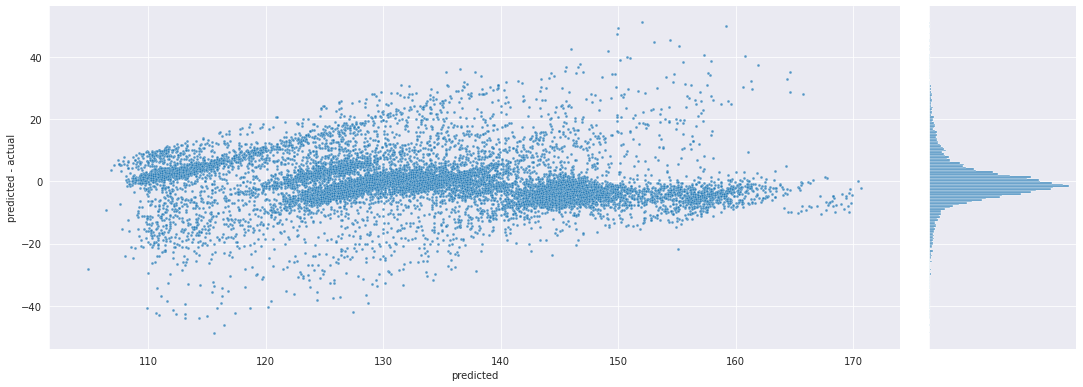

<Figure size 720x576 with 0 Axes>

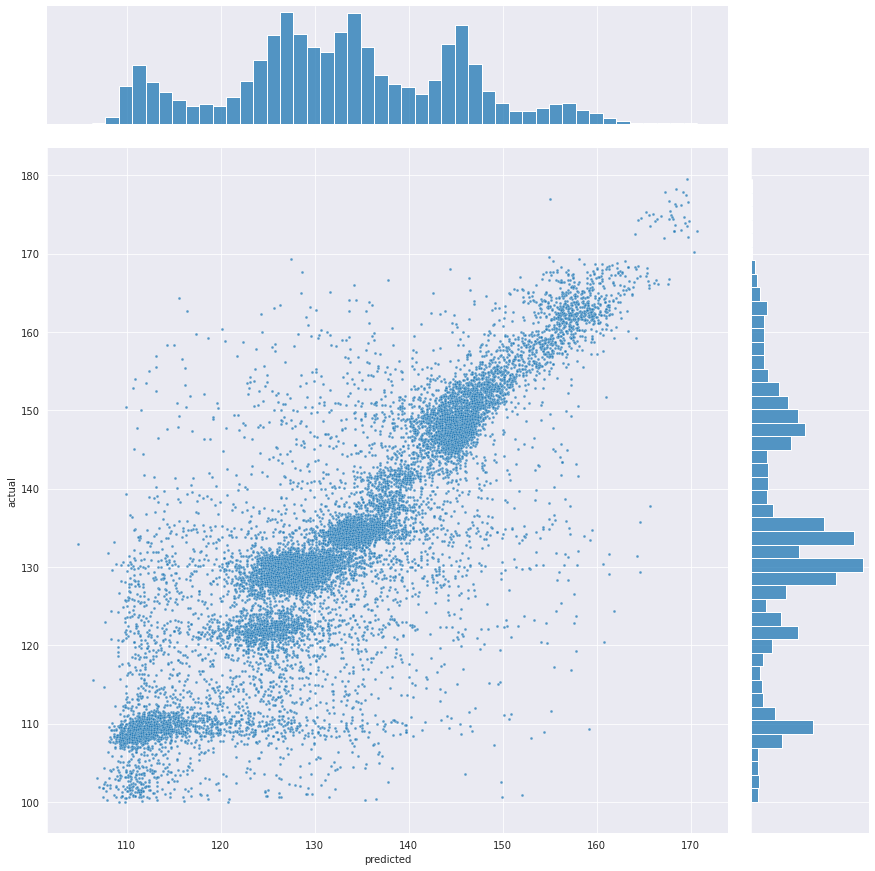

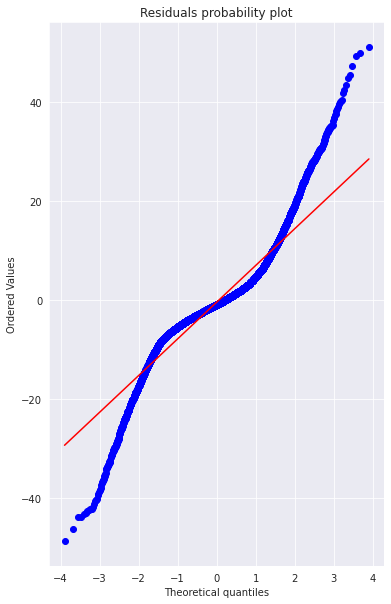

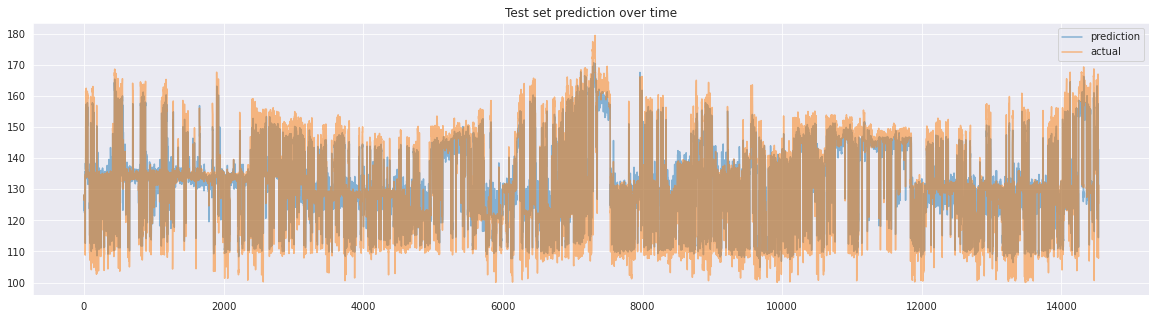

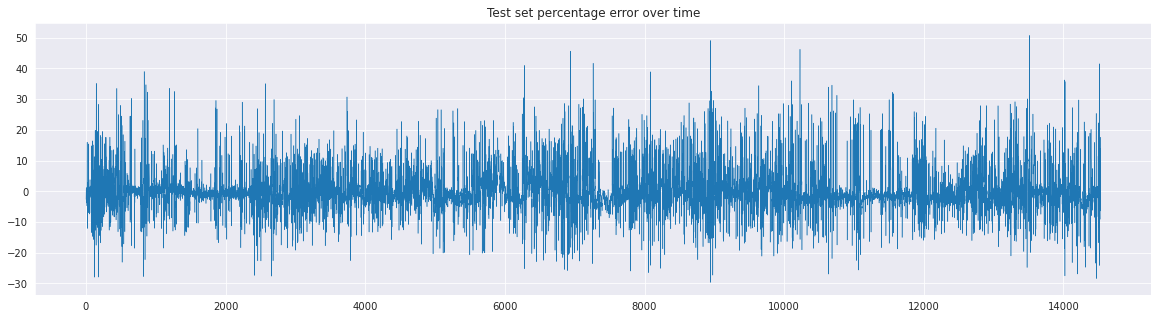

In [17]:
y_pred = model.predict(X_test)
util.evaluate(y_test.to_numpy(), y_pred)

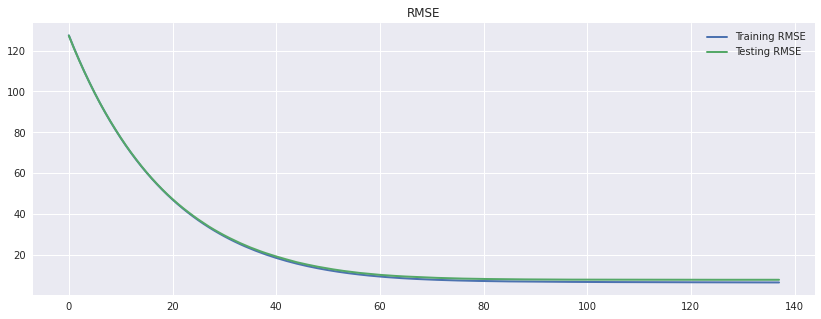

In [18]:
util.plot_history(model)

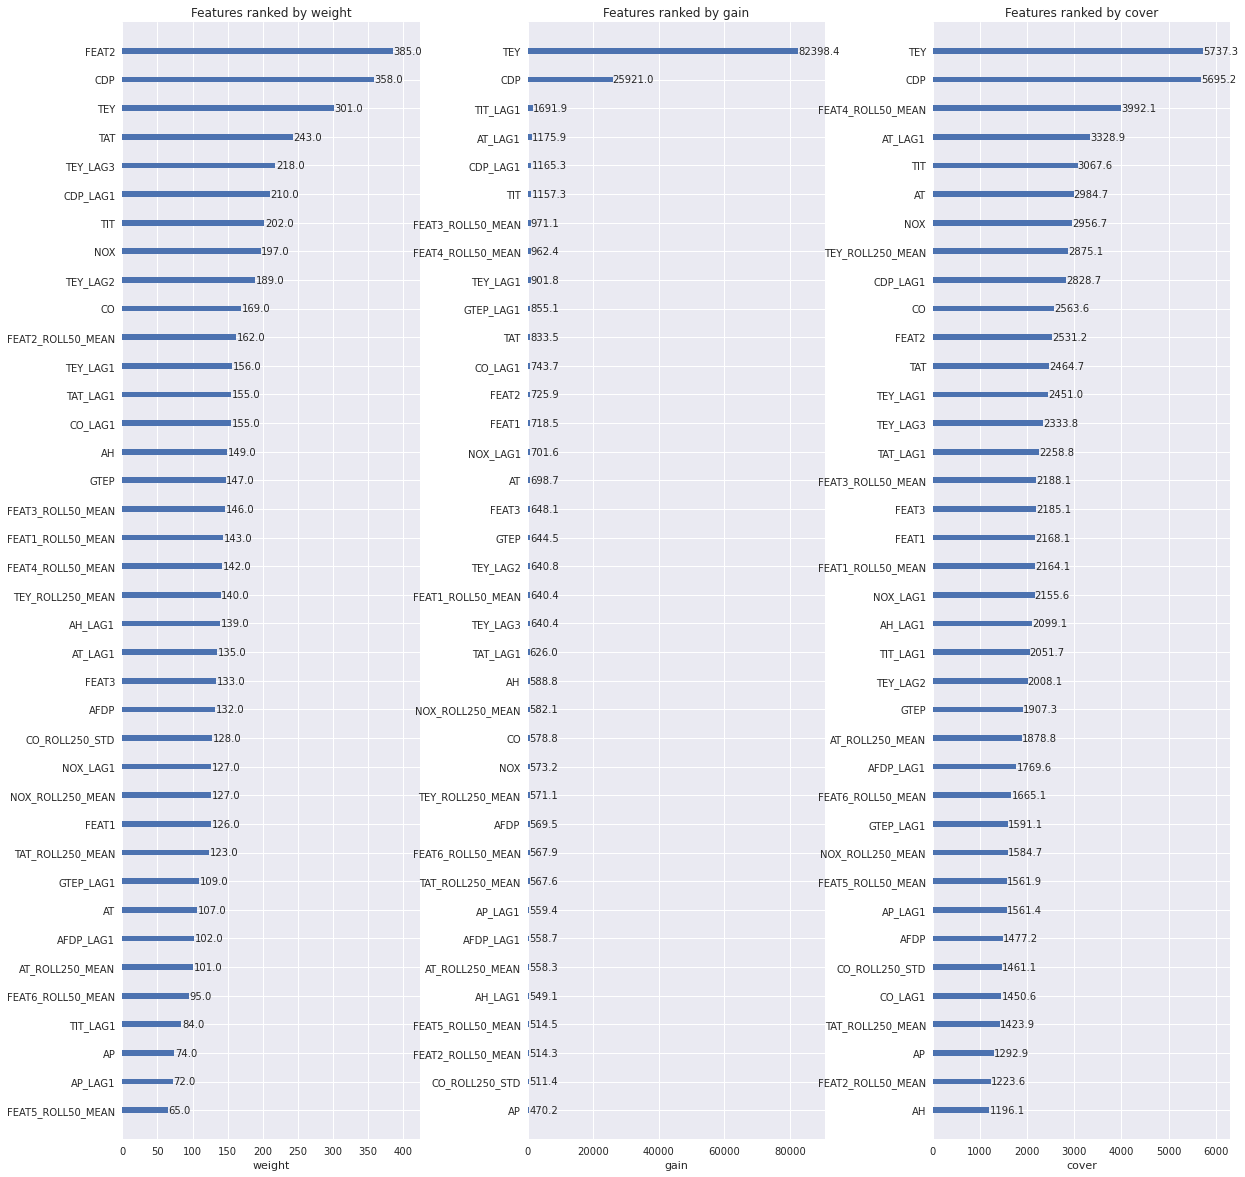

In [19]:
util.plot_importance(model)

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


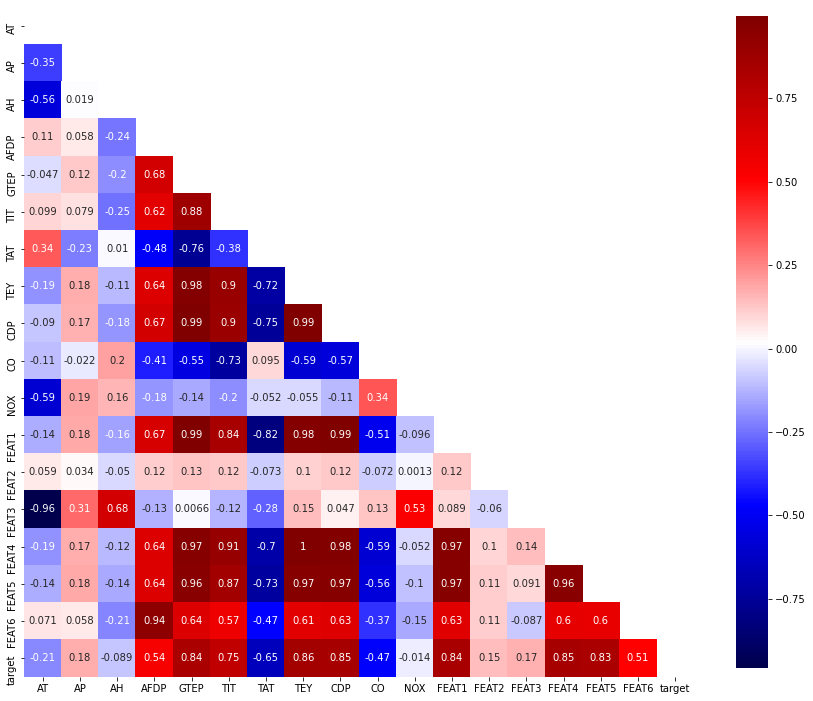

In [20]:
corr = (X_train
        .merge(
            y_train,
            left_index=True,
            right_index=True
        )[[col for col in X_train.columns if 'ROLL' not in col and 'LAG' not in col] + ['target']].corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 15))
sns.heatmap(corr, square=True, mask=mask, cmap="seismic",
            annot=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 10});

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


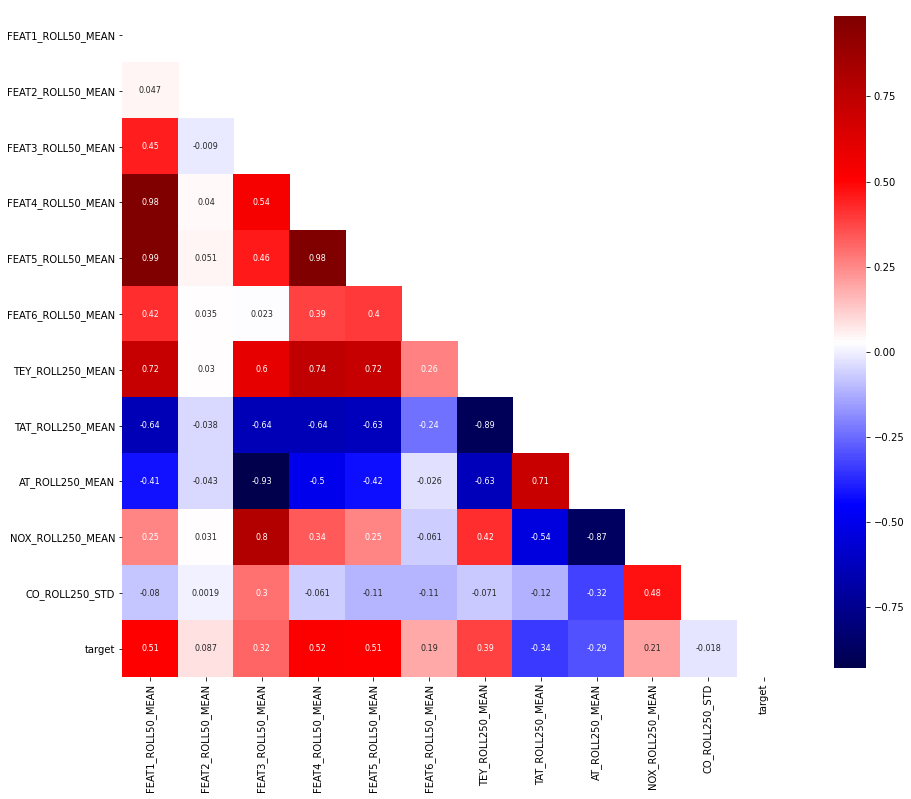

In [21]:
corr = X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train.columns if 'ROLL' in col] + ['target']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 15))
sns.heatmap(corr, square=True, mask=mask, cmap="seismic",
            annot=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 8});

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


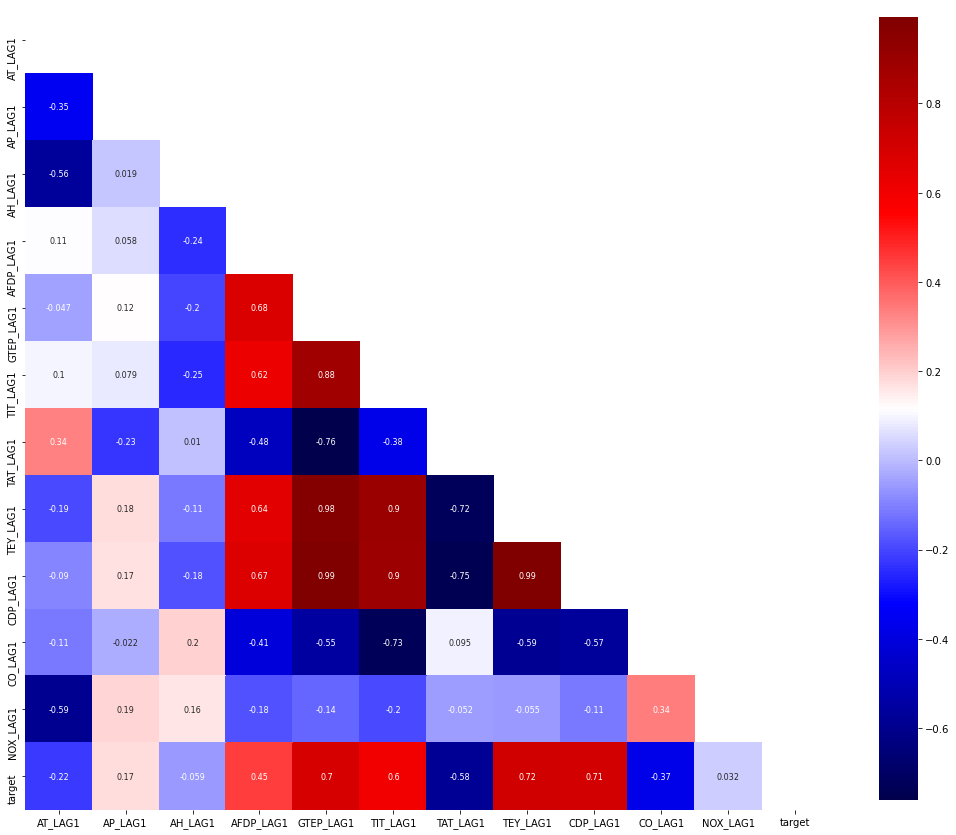

In [22]:
corr = X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train.columns if 'LAG1' in col] + ['target']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 18))
sns.heatmap(corr, square=True, mask=mask, cmap="seismic",
            annot=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 8});

<AxesSubplot:>

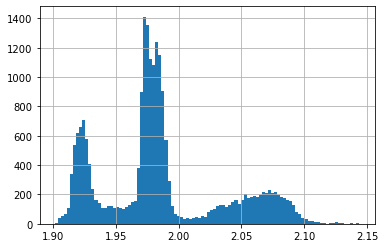

In [23]:
(X_train["TIT"]/X_train["TAT"]).hist(bins=100)

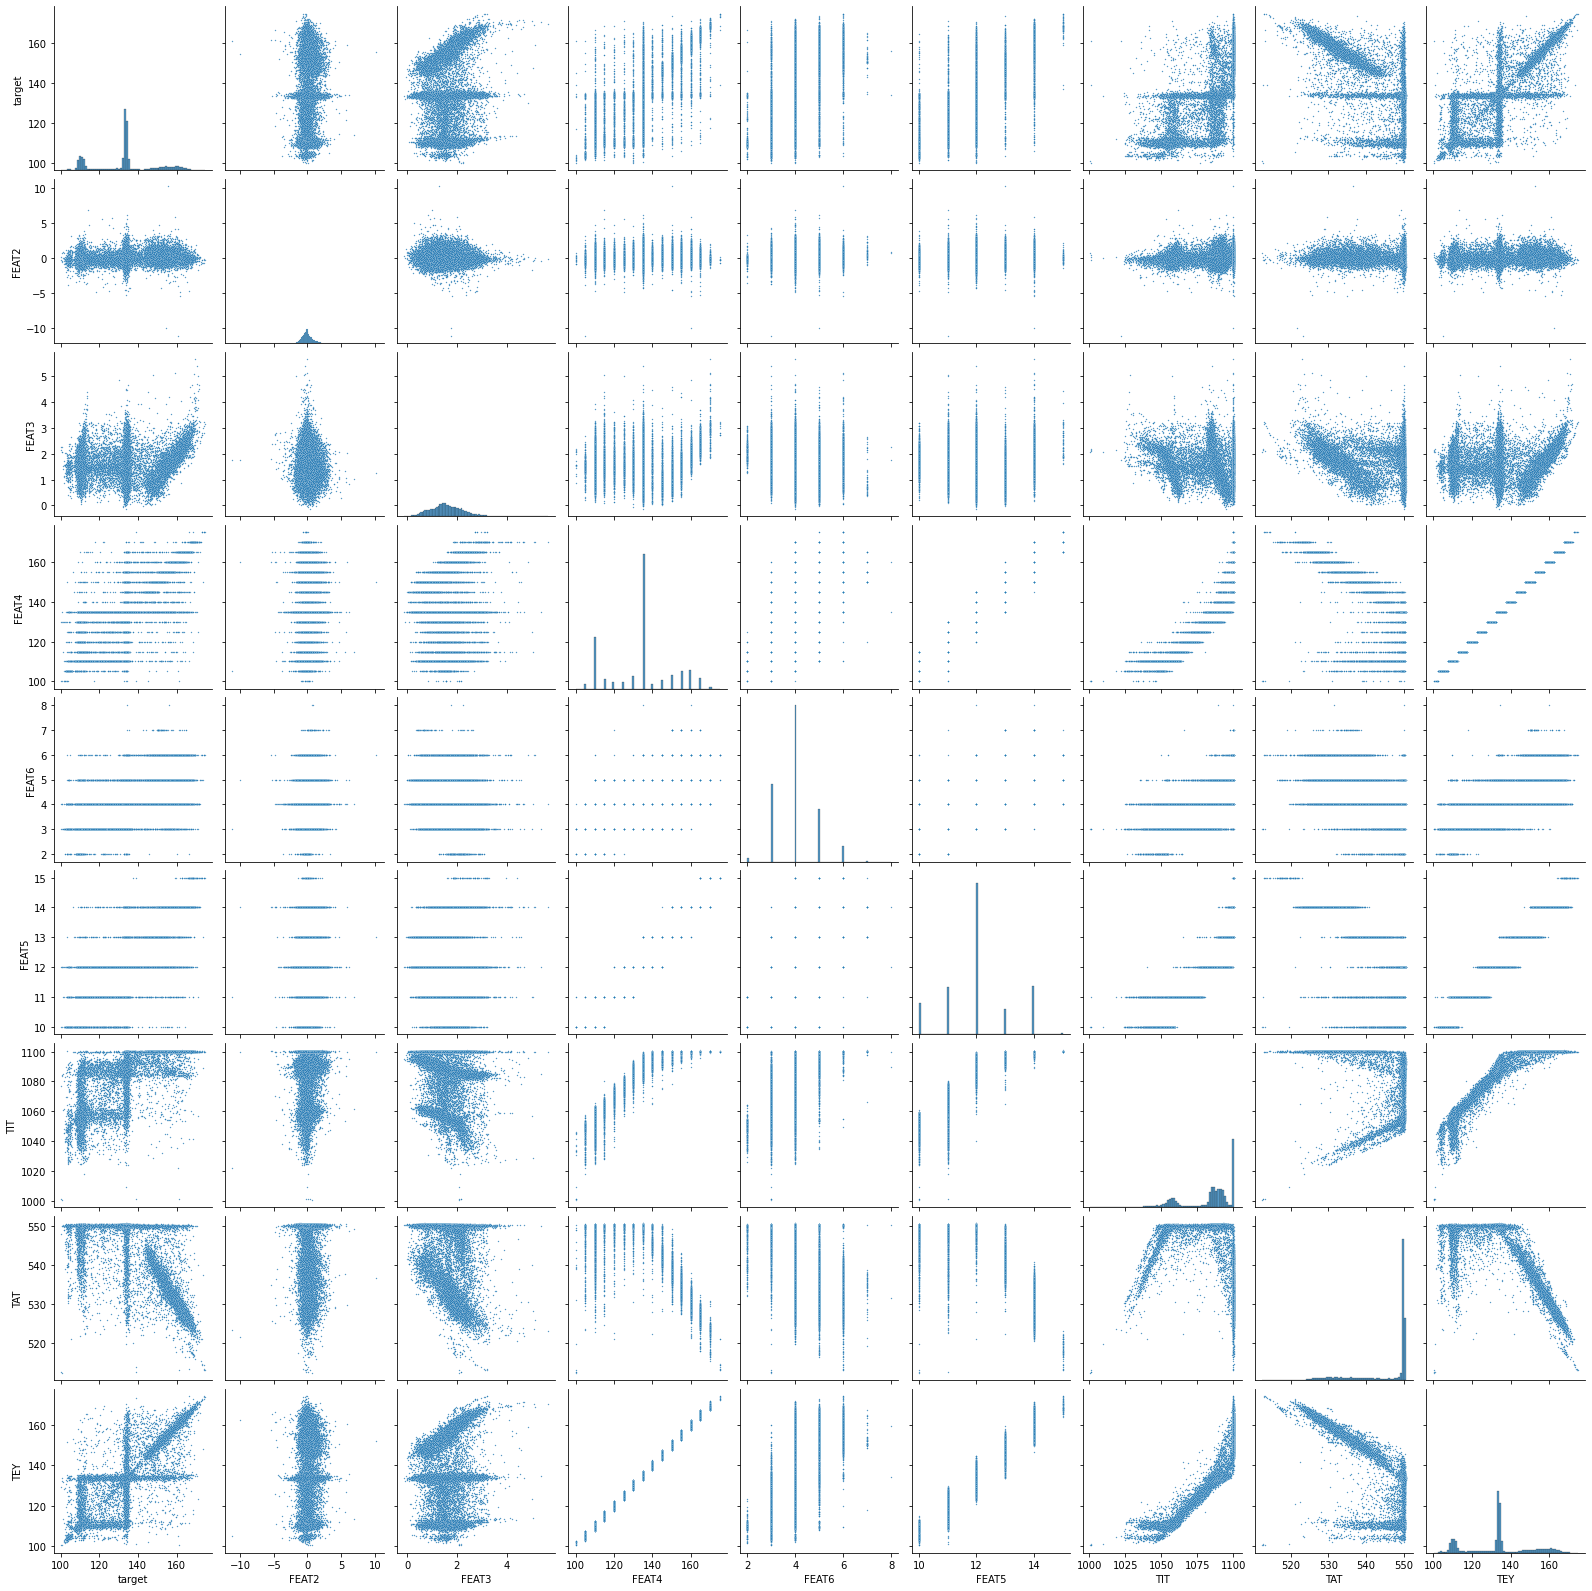

In [24]:
sns.pairplot(X_train.merge(y_train, left_index=True, right_index=True)[['target', 'FEAT2', 'FEAT3', 'FEAT4', 'FEAT6', 'FEAT5', 'TIT', 'TAT', 'TEY']], 
             plot_kws={"alpha": 0.75, "s": 2})

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


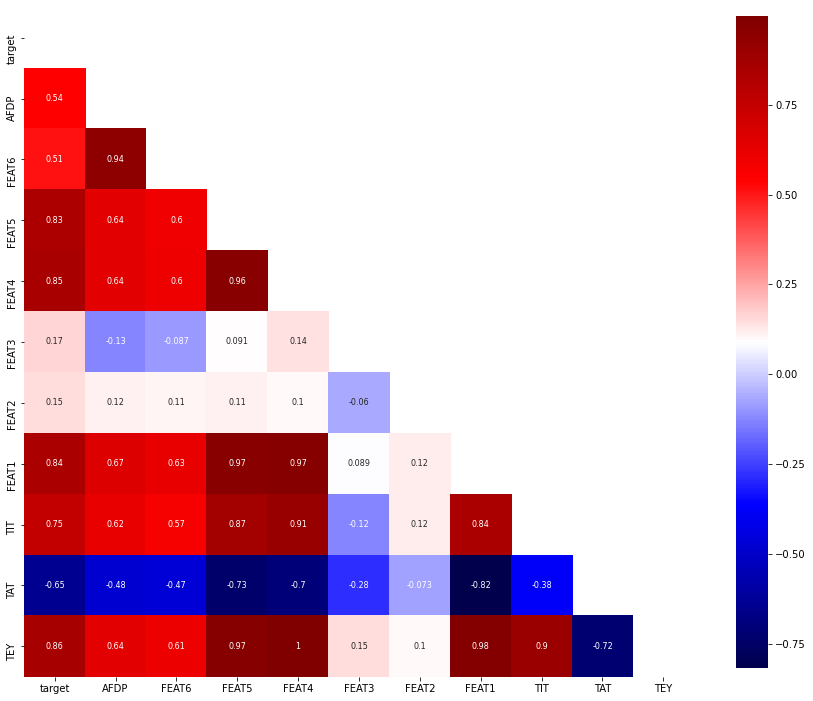

In [25]:
corr = X_train.merge(y_train, left_index=True, right_index=True)[['target', 'AFDP', 'FEAT6', 'FEAT5', 'FEAT4', 'FEAT3', 'FEAT2', 'FEAT1', 'TIT', 'TAT', 'TEY']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 15))
sns.heatmap(corr, square=True, mask=mask, cmap="seismic",
            annot=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 8});

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

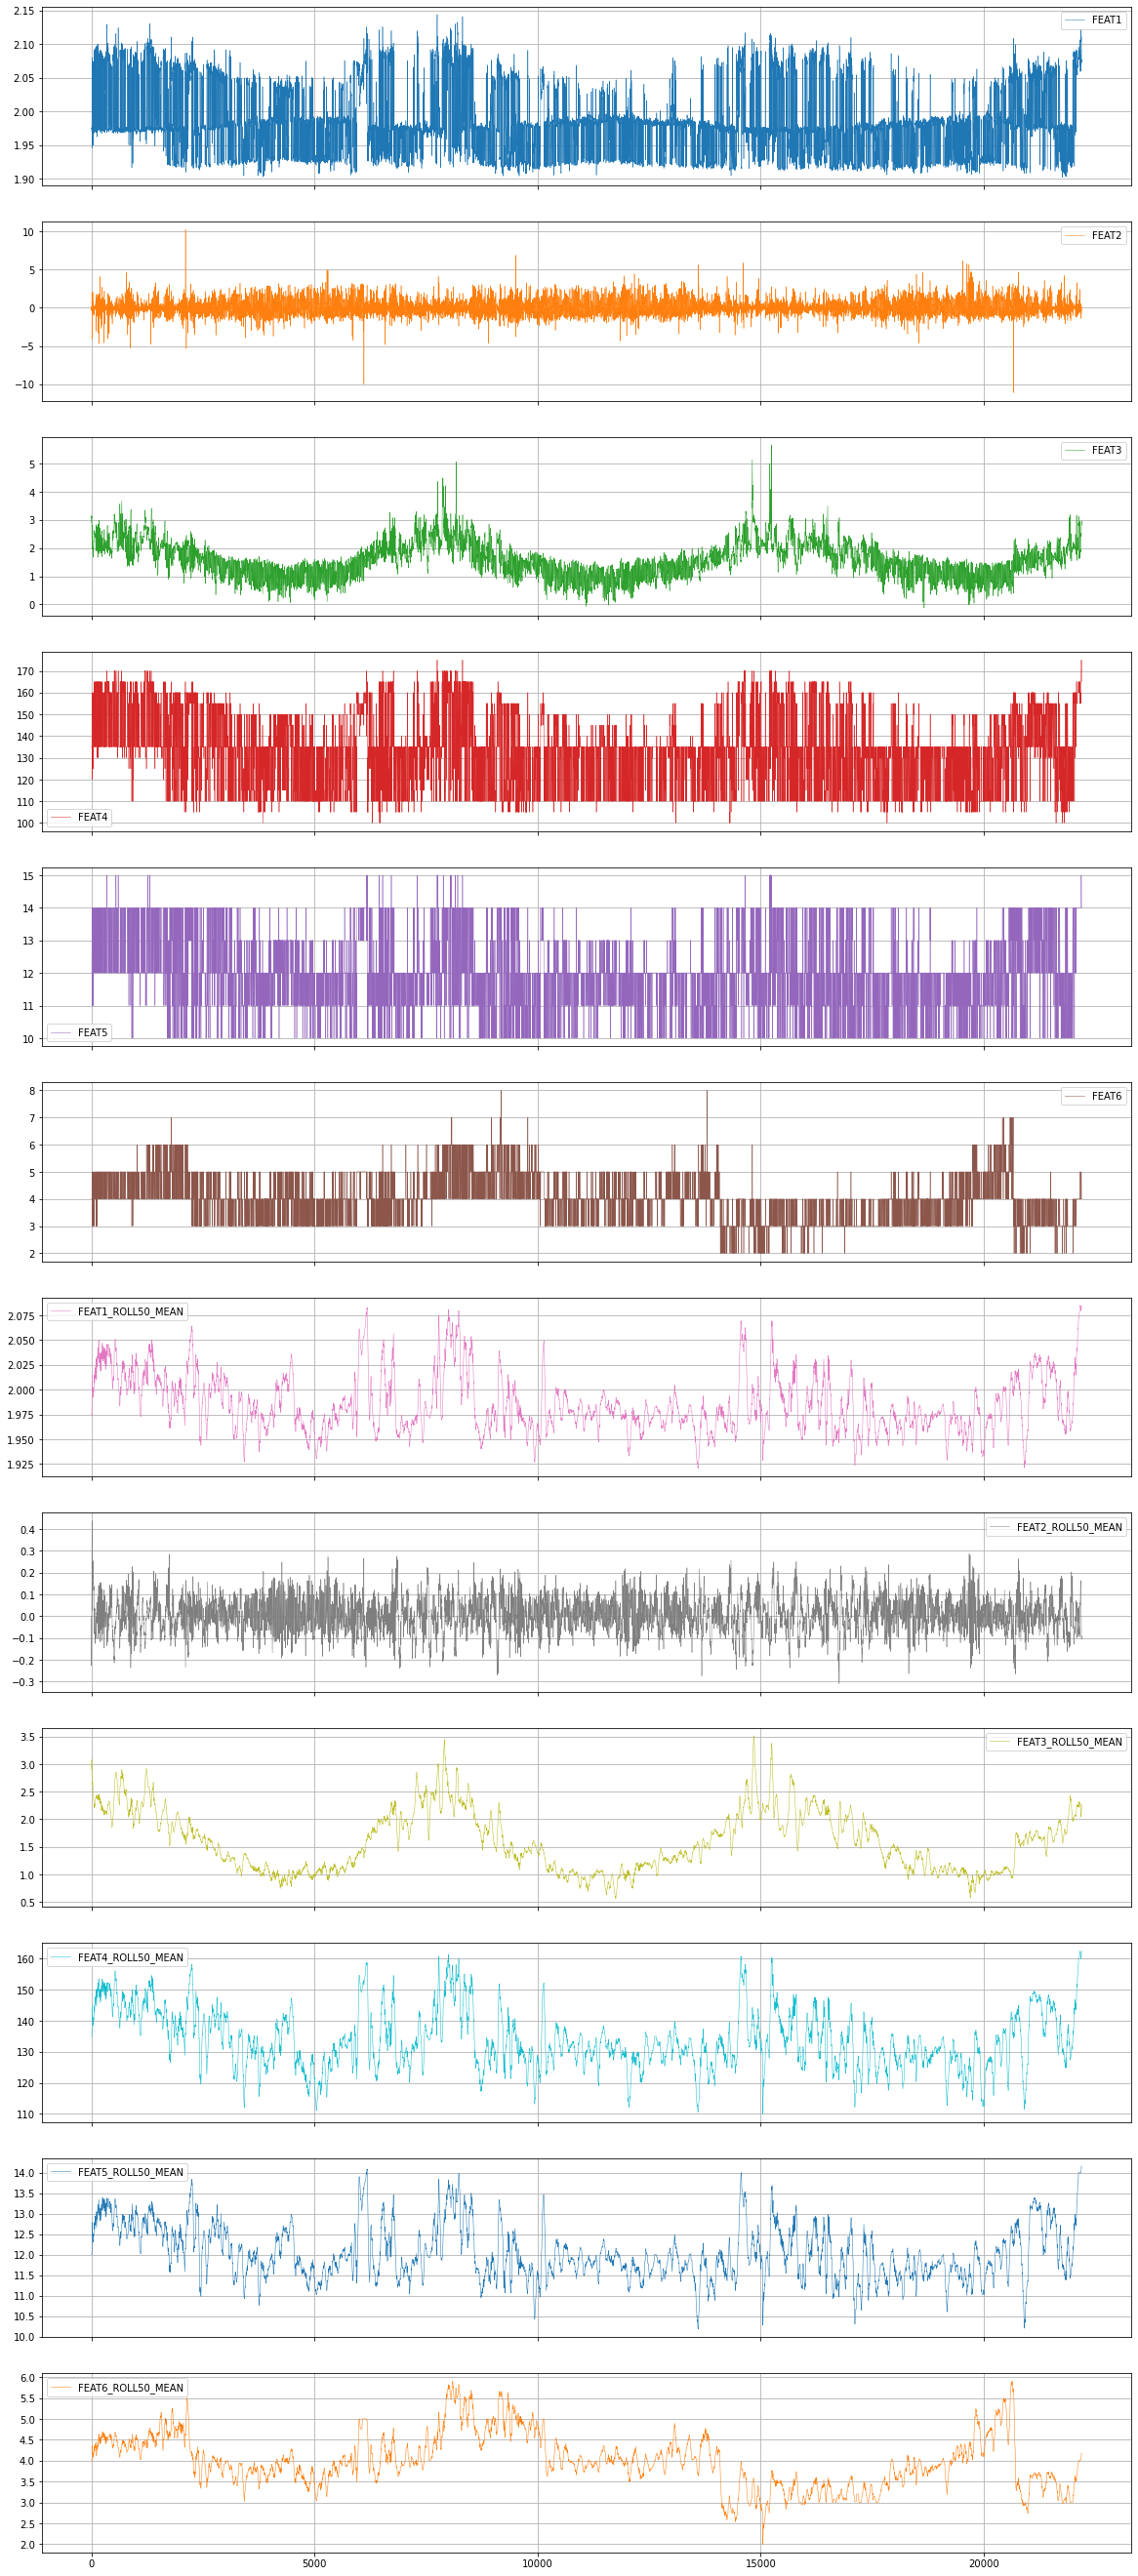

In [30]:
# X_train["FEAT1"] = X_train["TIT"]/X_train["TAT"]
# X_train["FEAT2"] = X_train['AT'].diff().fillna(0)
# X_train["FEAT3"] = np.log(np.abs(X_train["AH"]/X_train["AT"]))
# X_train["FEAT4"] = 5*np.round(X_train["TEY"]/5)
# X_train["FEAT5"] = np.round(X_train["CDP"])
# X_train["FEAT6"] = np.round(X_train["AFDP"])

(X_train[[col for col in X_train.columns if "FEAT" in col]]
 .plot.line(subplots=True, figsize=(20, 48), linewidth=0.5, grid=True))